In [1]:
import numpy as np
import scipy.sparse as sp
import torch
import torch.nn as nn
import torch.nn.functional as F

from scipy.linalg import eigh

from Mesh import Mesh

import matplotlib.pyplot as plt


In [2]:
# ------------------------
# Helpers to convert sparse to torch
# ------------------------
def scipy_to_torch_sparse(spmat, device):
    spmat = sp.coo_matrix(spmat)
    i = torch.LongTensor(np.vstack((spmat.row, spmat.col)))
    v = torch.FloatTensor(spmat.data)
    return torch.sparse_coo_tensor(i, v, spmat.shape, device=device)

# ------------------------
# Network: outputs k eigenfunctions
# ------------------------
class MultiEigenNet(nn.Module):
    def __init__(self, in_dim, hidden, k):
        super().__init__()
        layers = []
        dims = [in_dim] + hidden
        for a, b in zip(dims[:-1], dims[1:]):
            layers.append(nn.Linear(a, b))
            layers.append(nn.ReLU())
        # final linear to k outputs
        layers.append(nn.Linear(dims[-1], k))
        self.net = nn.Sequential(*layers)
        # trainable eigenvalues (positive reparam)
        self.log_lambda = nn.Parameter(torch.randn(k) - 3.0)  # start small
    def forward(self, x):
        return self.net(x)  # shape (n, k)
    def lambdas(self):
        return torch.exp(self.log_lambda)  # positive eigenvalue estimates

# ------------------------
# Loss terms
# ------------------------
def mass_inner(X, Y, M_torch):
    # X, Y are (n, k) or (n, ). compute X^T M Y -> (k,k) or scalar
    # using sparse matmul: M @ Y  then X.T @ (M@Y)
    # Convert to dense if shapes small
    # M_torch: sparse_coo_tensor shape (n,n)
    MY = torch.sparse.mm(M_torch, Y)            # (n, k)
    return X.t() @ MY                           # (k, k)

def residual_loss(U, K_torch, M_torch, lambdas):
    # U: (n, k), lambdas: (k,)
    KU = torch.sparse.mm(K_torch, U)            # (n, k)
    MU = torch.sparse.mm(M_torch, U)            # (n, k)
    # compute residuals R = KU - MU * lambda (broadcast)
    R = KU - MU * lambdas.view(1, -1)
    # M-weighted residual norm: sum_i r_i^T M r_i = trace(R.T M R)
    M_R = torch.sparse.mm(M_torch, R)           # (n,k)
    # trace(R^T (M R)) = sum over k of (R[:,i] * (M_R)[:,i]).sum()
    res_sq = (R * M_R).sum()
    return res_sq

def orthonormality_loss(U, M_torch):
    # Want U^T M U ≈ I
    G = mass_inner(U, U, M_torch)  # (k,k)
    I = torch.eye(G.shape[0], device=G.device)
    return F.mse_loss(G, I)

# ------------------------
# Example training harness
# ------------------------
def train_multi_eigen(V, K_scipy, M_scipy, k=10,
                      hidden=[128,128], lr=1e-3, epochs=3000,
                      device=None):
    device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
    n, d = V.shape
    # Convert inputs
    V_t = torch.tensor(V, dtype=torch.float32, device=device)   # (n,d)
    K_t = scipy_to_torch_sparse(K_scipy, device)
    M_t = scipy_to_torch_sparse(M_scipy, device)

    model = MultiEigenNet(in_dim=d, hidden=hidden, k=k).to(device)
    optim = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        optim.zero_grad()

        U = model(V_t)                       # (n, k)
        lambdas = model.lambdas()            # (k,)

        rloss = residual_loss(U, K_t, M_t, lambdas)
        onorm = orthonormality_loss(U, M_t)

        # Small regularization to keep lambdas ordered (optional)
        # reorder loss encourages ascending lambda values:
        sorted_l = torch.sort(lambdas)[0]
        order_loss = F.mse_loss(lambdas, sorted_l.detach())

        loss = rloss + 50.0 * onorm + 1e-3 * order_loss

        loss.backward()
        optim.step()

        if epoch % 200 == 0 or epoch == epochs-1:
            with torch.no_grad():
                # Compute Rayleigh quotients for monitoring
                KU = torch.sparse.mm(K_t, U)
                MU = torch.sparse.mm(M_t, U)
                # λ_est_i = (u_i^T K u_i) / (u_i^T M u_i)
                numer = (U * KU).sum(dim=0)
                denom = (U * MU).sum(dim=0)
                rq = (numer / denom).cpu().numpy()
            print(f"Epoch {epoch:4d}, Loss={loss.item():.4e}, Resid={rloss.item():.4e}, Ortho={onorm.item():.4e}")
            #print("  Rayleigh (est):", np.round(rq, 6))

    # After training, orthonormalize U w.r.t M (optional) via M-orthonormal Gram-Schmidt
    with torch.no_grad():
        U = model(V_t)                          # (n,k)
        # perform M-orthonormalization (simple symmetric orthonormalization)
        G = mass_inner(U, U, M_t).cpu().numpy()   # (k,k)
        # symmetric orthonormalization: W = U * (G^{-1/2})
        import scipy.linalg as la
        eigvalsG, eigvecsG = la.eigh(G)
        Ginv_sqrt = eigvecsG @ np.diag(1.0/np.sqrt(np.maximum(eigvalsG, 1e-12))) @ eigvecsG.T
        Ginv_sqrt_t = torch.tensor(Ginv_sqrt, dtype=torch.float32, device=device)
        U_orth = U @ Ginv_sqrt_t                 # (n,k) now approx M-orthonormal
        # compute final Rayleigh quotients
        KU = torch.sparse.mm(K_t, U_orth)
        MU = torch.sparse.mm(M_t, U_orth)
        numer = (U_orth * KU).sum(dim=0)
        denom = (U_orth * MU).sum(dim=0)
        lambdas_final = (numer / denom).cpu().numpy()
    return U_orth.cpu().numpy(), lambdas_final

In [ ]:
m = Mesh('data/coil_1.2_MM.obj')

centroid = m.verts.mean(0)
std_max = m.verts.std(0).max()

verts_new = (m.verts - centroid)/std_max

m = Mesh(verts = verts_new, connectivity = m.connectivity)

print('Computing Laplacian')
K, M = m.computeLaplacian()

# following Finite Elements methodology 
# K is stiffness matrix, M is mass matrix
# The problem to solve becomes 
# K*u = lambda * M*u
print('Computing eigen values')
eigvals, eigvecs = eigh(K,M)

Computing Laplacian
Computing eigen values


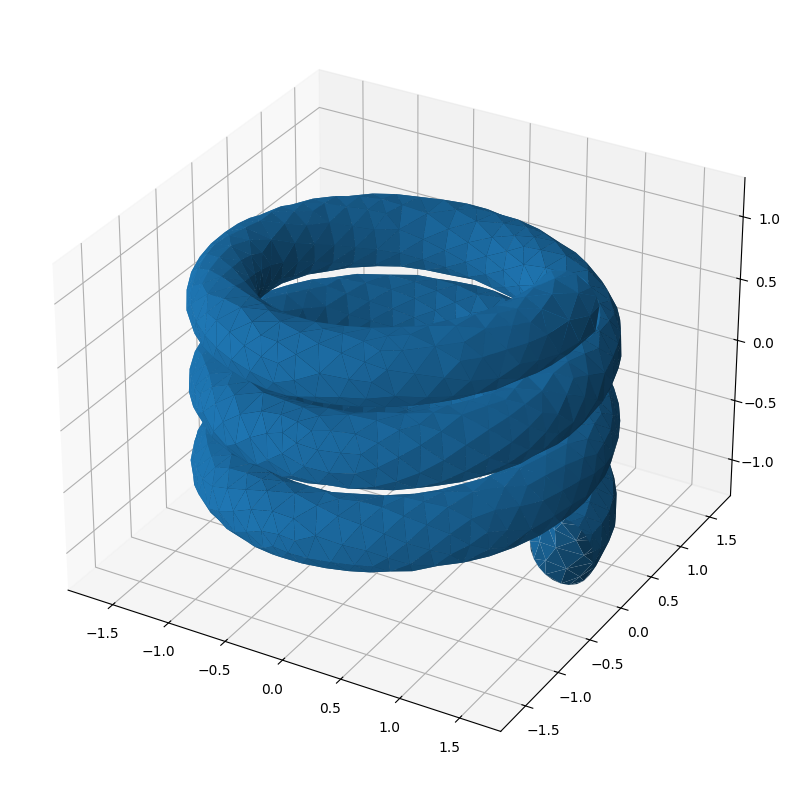

In [4]:
ax =  plt.figure(figsize=(10,10)).add_subplot(projection='3d')
surf = ax.plot_trisurf(m.verts[:,0], m.verts[:,1], m.verts[:,2], triangles = m.connectivity)
plt.show()

In [ ]:
U, lambdas_final = train_multi_eigen(m.verts, K, M, k=10, epochs=100_000)

In [9]:
lambdas_final

array([0.6929038 , 0.06234638, 2.4691966 , 0.32027426, 1.1103752 ,
       1.096418  , 0.20471379, 0.260799  , 2.4626875 , 4.3800225 ],
      dtype=float32)

In [10]:
eigvals

array([3.50308915e-13, 7.57414444e-03, 3.03079128e-02, ...,
       3.72142349e+04, 3.73586066e+04, 4.61850521e+04], shape=(1546,))

In [11]:
K.shape

(1546, 1546)

In [12]:
M.shape

(1546, 1546)